In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image
!pip install scikit-learn
!pip install tensorflow


In [2]:
import os
import zipfile

# Define the zip file paths (update these paths to match your local files)
first_zip = 'First Print-20250322T093756Z-001.zip'
second_zip = 'Second Print-20250322T093757Z-001.zip'

# Define extraction directories
first_dir = 'dataset/first_print'
second_dir = 'dataset/second_print'

def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

extract_zip(first_zip, first_dir)
extract_zip(second_zip, second_dir)


Extracted First Print-20250322T093756Z-001.zip to dataset/first_print
Extracted Second Print-20250322T093757Z-001.zip to dataset/second_print


Number of first prints (original): 100
Number of second prints (counterfeit): 100
Dataset distribution: Counter({'original': 100, 'counterfeit': 100})


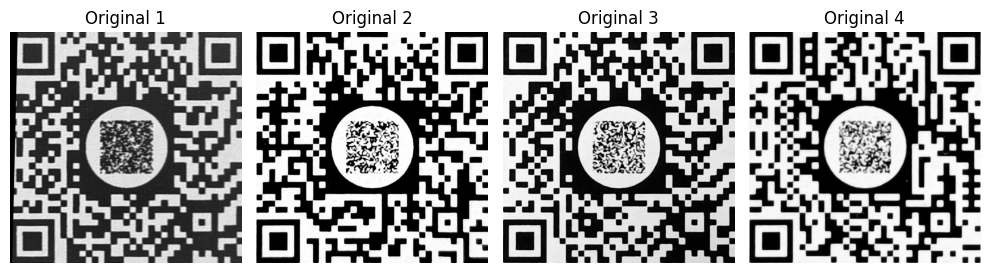

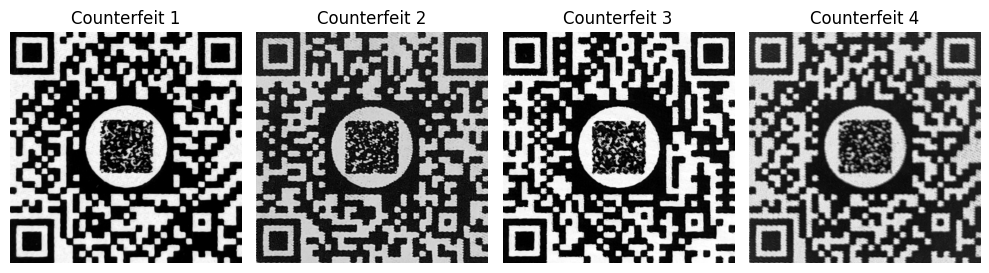

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return images, filenames

# Load images from both classes
first_images, first_filenames = load_images_from_folder(first_dir)
second_images, second_filenames = load_images_from_folder(second_dir)

# Print basic statistics
print("Number of first prints (original):", len(first_images))
print("Number of second prints (counterfeit):", len(second_images))
print("Dataset distribution:", Counter(["original"] * len(first_images) + ["counterfeit"] * len(second_images)))

# Function to display a few sample images
def show_sample_images(images, title, num_samples=4):
    plt.figure(figsize=(10, 3))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(first_images, "Original")
show_sample_images(second_images, "Counterfeit")


In [7]:
from skimage.feature import local_binary_pattern, hog

def extract_lbp_features(image, radius=3, n_points=24):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_hog_features(image):
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return features

def extract_features(images):
    feature_list = []
    for img in images:
        # Resize the image for consistency
        img_resized = cv2.resize(img, (128, 128))
        lbp_feat = extract_lbp_features(img_resized)
        hog_feat = extract_hog_features(img_resized)
        combined = np.hstack([lbp_feat, hog_feat])
        feature_list.append(combined)
    return np.array(feature_list)

# Extract features for both classes
features_first = extract_features(first_images)
features_second = extract_features(second_images)

# Create labels (0 for original, 1 for counterfeit)
labels_first = np.zeros(len(features_first))
labels_second = np.ones(len(features_second))

# Combine features and labels
X = np.vstack([features_first, features_second])
y = np.hstack([labels_first, labels_second])
print("Feature matrix shape:", X.shape)


Feature matrix shape: (200, 8126)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Random Forest Confusion Matrix:
[[20  0]
 [ 0 20]]


In [9]:
import os
import shutil
import random

# Set the random seed for reproducibility
random.seed(42)

# Source directories
source_dirs = {
    'original': 'dataset/first_print/First Print',
    'counterfeit': 'dataset/second_print/Second Print'
}

# Destination base directory
dest_base = 'dataset_cnn'
train_ratio = 0.8  # 80% for training

# Create destination directories
for label in source_dirs.keys():
    train_dir = os.path.join(dest_base, 'train', label)
    val_dir = os.path.join(dest_base, 'validation', label)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

# Split and copy images
for label, src in source_dirs.items():
    # Get list of image files from the source directory
    files = [f for f in os.listdir(src) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    random.shuffle(files)

    # Calculate split index
    train_count = int(len(files) * train_ratio)
    train_files = files[:train_count]
    val_files = files[train_count:]

    # Copy files to train folder
    for f in train_files:
        src_path = os.path.join(src, f)
        dst_path = os.path.join(dest_base, 'train', label, f)
        shutil.copy(src_path, dst_path)

    # Copy files to validation folder
    for f in val_files:
        src_path = os.path.join(src, f)
        dst_path = os.path.join(dest_base, 'validation', label, f)
        shutil.copy(src_path, dst_path)

print("Dataset organized successfully!")


Dataset organized successfully!


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths for training and validation directories
train_dir = 'dataset_cnn/train'
val_dir = 'dataset_cnn/validation'

# Data augmentation for training data and rescaling for both training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    color_mode='grayscale',  # Adjust based on your images
    batch_size=32,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Accuracy:", val_acc)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 779ms/step - accuracy: 0.4502 - loss: 1.1441 - val_accuracy: 0.5000 - val_loss: 0.7095
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 829ms/step - accuracy: 0.5049 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step - accuracy: 0.4571 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6846
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.5938 - loss: 0.6864 - val_accuracy: 0.5000 - val_loss: 0.6824
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step - accuracy: 0.5622 - loss: 0.6858 - val_accuracy: 0.9000 - val_loss: 0.6650
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 856ms/step - accuracy: 0.6534 - loss: 0.6715 - val_accuracy: 0.9000 - val_loss: 0.6382
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.7245 - loss: 0.6450 - val_accuracy: 0.8250 - val_loss: 0.5864
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - accuracy: 0.7183 - loss: 0.6123 - val_accuracy: 0.8750 - val_loss:

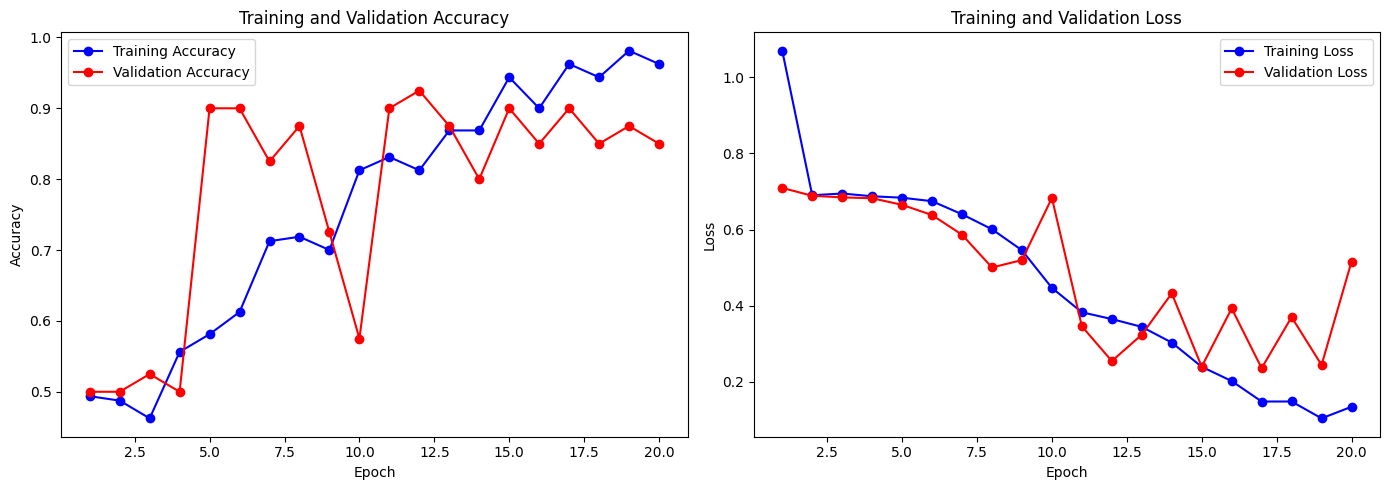

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
Confusion Matrix:
[[13  7]
 [11  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.65      0.59        20
           1       0.56      0.45      0.50        20

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40



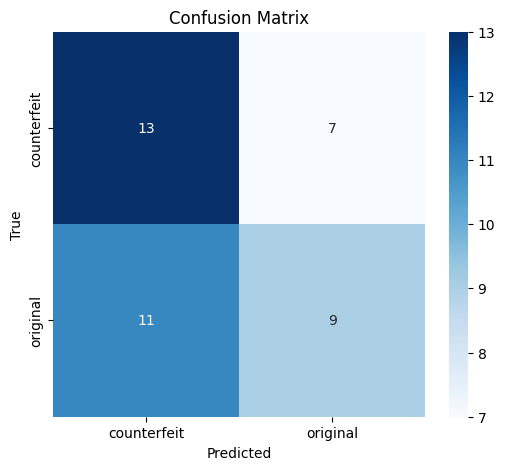

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot training & validation accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions on the validation set for confusion matrix
# Note: steps can be set to cover all validation images.
val_steps = val_generator.samples // val_generator.batch_size + 1
val_generator.reset()  # Reset generator before predictions
predictions = model.predict(val_generator, steps=val_steps)
# Convert probabilities to binary labels (0 or 1)
y_pred = (predictions > 0.5).astype("int32")

# True labels from generator
y_true = val_generator.classes

# Create confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Optionally, plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths for your organized dataset
train_dir = 'dataset_cnn/train'
val_dir = 'dataset_cnn/validation'

# Update the data generators for RGB images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,  # Typically, vertical flip may not be appropriate
    shear_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    color_mode='rgb',  # Use 'rgb' for MobileNetV2
    batch_size=16,  # Lower batch size for small datasets
    class_mode='binary',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=16,
    class_mode='binary',
    shuffle=False  # For consistent evaluation ordering
)

# Load the pre-trained MobileNetV2 model (without the top classification layer)
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model to use as a feature extractor

# Build the transfer learning model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Use a lower learning rate for fine-tuning
initial_lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Define callbacks: EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint('best_model_transfer.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks_list
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Accuracy (Transfer Learning):", val_acc)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6538 - loss: 0.7306
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to best_model_transfer.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6506 - loss: 0.7314 - val_accuracy: 0.5250 - val_loss: 0.6516 - learning_rate: 1.0000e-04
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6099 - loss: 0.7380
Epoch 2: val_accuracy improved from 0.52500 to 0.70000, saving model to best_model_transfer.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - accuracy: 0.6096 - loss: 0.7355 - val_accuracy: 0.7000 - val_loss: 0.5632 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7158 - loss: 0.5844
Epoch 3: val_accuracy improved from 0.70000 to 0.90000, saving model to best_model_transfer.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - accuracy: 0.7143 - loss: 0.5843 - val_accuracy: 0.9000 - val_loss: 0.5040 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━

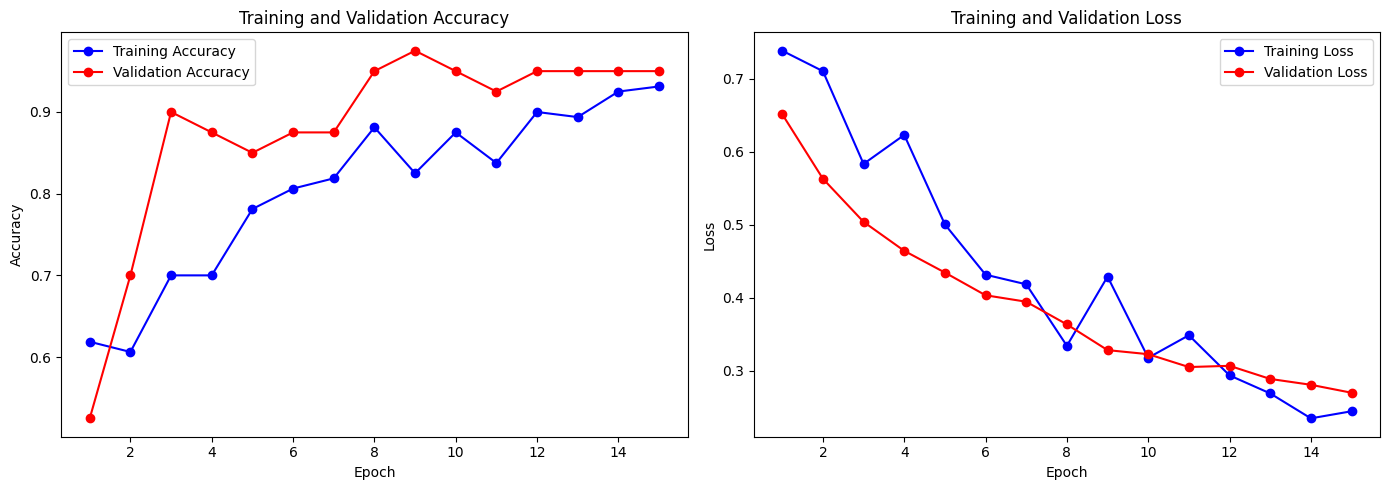

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Confusion Matrix:
[[18  2]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



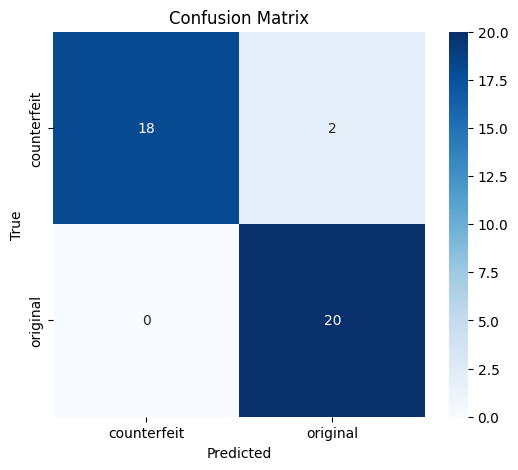

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot training & validation accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions on the validation set for confusion matrix
# Note: steps can be set to cover all validation images.
val_steps = val_generator.samples // val_generator.batch_size + 1
val_generator.reset()  # Reset generator before predictions
predictions = model.predict(val_generator, steps=val_steps)
# Convert probabilities to binary labels (0 or 1)
y_pred = (predictions > 0.5).astype("int32")

# True labels from generator
y_true = val_generator.classes

# Create confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Optionally, plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
# Save the transfer learning model in the native Keras format
model.save('qr_authentication_transfer_model.keras')
print("Transfer learning model saved as 'qr_authentication_transfer_model.keras'")

# Optionally, convert the model to TensorFlow Lite for deployment on mobile/edge devices
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('qr_authentication_transfer_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Transfer learning model converted to TensorFlow Lite and saved as 'qr_authentication_transfer_model.tflite'")


Transfer learning model saved as 'qr_authentication_transfer_model.keras'
Saved artifact at '/tmp/tmp2c3uxwsc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_215')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133814473573008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473579344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473578384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473578576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473578960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473580112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473580496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473580880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814473580688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133814

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Function to load grayscale images from a folder
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return images, filenames

# Set directories for original and counterfeit images
first_dir = 'dataset/first_print/First Print'
second_dir = 'dataset/second_print/Second Print'

# Load images
first_images, _ = load_images_from_folder(first_dir)
second_images, _ = load_images_from_folder(second_dir)
print("Original images loaded:", len(first_images))
print("Counterfeit images loaded:", len(second_images))

# Feature extraction functions
def extract_lbp_features(image, radius=3, n_points=24):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_hog_features(image):
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return features

def extract_features(images):
    feature_list = []
    for img in images:
        # Resize image for consistency
        img_resized = cv2.resize(img, (128, 128))
        lbp_feat = extract_lbp_features(img_resized)
        hog_feat = extract_hog_features(img_resized)
        combined = np.hstack([lbp_feat, hog_feat])
        feature_list.append(combined)
    return np.array(feature_list)

# Extract features and create labels (0 = original, 1 = counterfeit)
features_first = extract_features(first_images)
features_second = extract_features(second_images)
labels_first = np.zeros(len(features_first))
labels_second = np.ones(len(features_second))

# Combine data and labels
X = np.vstack([features_first, features_second])
y = np.hstack([labels_first, labels_second])
print("Feature matrix shape:", X.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest (Traditional CV) Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Original images loaded: 100
Counterfeit images loaded: 100
Feature matrix shape: (200, 8126)
Random Forest (Traditional CV) Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
[[20  0]
 [ 0 20]]


In [21]:
import joblib

joblib.dump(rf_clf, 'rf_qr_authentication_model.joblib')
print("Random Forest model saved as 'rf_qr_authentication_model.joblib'")


Random Forest model saved as 'rf_qr_authentication_model.joblib'


In [22]:
from sklearn.metrics import accuracy_score

# Suppose you already computed the following:
# For the transfer learning approach (using the MobileNetV2 model)
transfer_val_acc = 0.95  # Replace with your evaluated accuracy

# For the traditional Random Forest approach:
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Transfer Learning Model Accuracy: {:.2f}".format(transfer_val_acc))
print("Traditional CV (Random Forest) Model Accuracy: {:.2f}".format(rf_accuracy))

# Optionally, create a summary table using pandas:
import pandas as pd

data = {
    'Approach': ['Transfer Learning (MobileNetV2)', 'Traditional CV (Random Forest)'],
    'Accuracy': [transfer_val_acc, rf_accuracy]
}
df = pd.DataFrame(data)
print(df)


Transfer Learning Model Accuracy: 0.95
Traditional CV (Random Forest) Model Accuracy: 1.00
                          Approach  Accuracy
0  Transfer Learning (MobileNetV2)      0.95
1   Traditional CV (Random Forest)      1.00


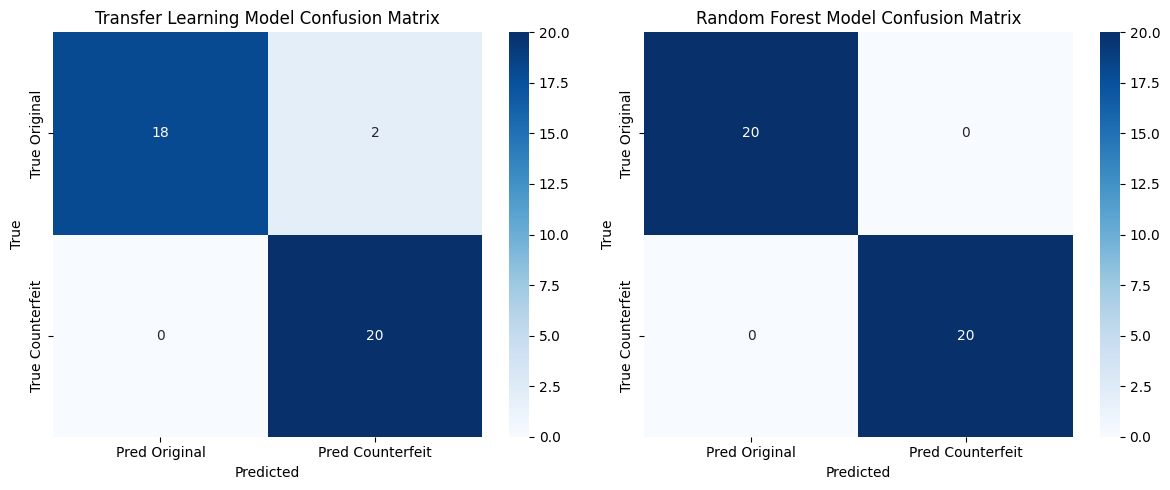

In [23]:
import seaborn as sns

# Confusion matrix for transfer learning model (example)
cm_transfer = np.array([[18, 2],
                        [0, 20]])
# Confusion matrix for traditional approach (from earlier)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Original','Pred Counterfeit'],
            yticklabels=['True Original','True Counterfeit'])
plt.title('Transfer Learning Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Original','Pred Counterfeit'],
            yticklabels=['True Original','True Counterfeit'])
plt.title('Random Forest Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()
